In [1]:
import datetime as dt
import os
import re

from dotenv import load_dotenv
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import sqlalchemy
from sqlalchemy import text

In [2]:
load_dotenv(dotenv_path='../.env')

user = os.environ.get('DB_USER')
password = os.environ.get('DB_PASS')
host = os.environ.get('HOST')
port = os.environ.get('DB_PORT')
database = os.environ.get('DB_NAME')

url = f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}'

engine = sqlalchemy.create_engine(url)

In [3]:
query = 'select * from races'
race_df = pd.read_sql_query(sql=text(query), con=engine.connect())

In [4]:
read_race_results = 'select * from race_results'
race_results_df = pd.read_sql_query(sql=text(read_race_results), con=engine.connect())

In [5]:
merge_df = pd.merge(race_df, race_results_df, on='id', how='left')
merge_df = merge_df.dropna(subset=["id"])

In [6]:
USE_COLUMNS = [
    "id", "race_name", "race_place", "number_of_entries", "race_state", "date",
    "rank", "box", "horse_order", "sex_and_age", "burden_weight",
    "jockey", "horse_weight", "horse_trainer", "horse_owner"
]

use_df = merge_df[USE_COLUMNS]

In [7]:
def get_race_state_features(df):
    return_df = df.copy()
    return_df["race_course"] = df["race_state"].str[1]
    return_df["race_distance"] = df["race_state"].str[2:6]
    return_df["race_weather"] = df["race_state"].str[15]
    return_df["race_state"] = df["race_state"].str[23]
    return_df["race_start"] =  df["race_state"].str[32:37].str.replace(":", "")
    return return_df

In [8]:
def get_sex_and_age(df):
    return_df = df.copy()
    return_df["sex"] = return_df["sex_and_age"].str[0]
    return_df["age"] = return_df["sex_and_age"].str[1]
    return return_df

In [9]:
def get_horse_weight(df):
    return_df = df.copy()
    return_df["difference_weight"] = return_df["horse_weight"].str[3:]
    return_df["difference_weight"] = return_df["difference_weight"].replace(re.compile("\(|\)"), "", regex=True)
    return_df[return_df['difference_weight'] == ''] = -9999
    return_df["difference_weight"] = return_df["difference_weight"].astype(int)
    return_df[return_df['difference_weight'] == -9999] = None
    return_df["horse_weight"] = return_df["horse_weight"].str[0:3]
    return return_df

In [10]:
def get_date(df):
    return_df = df.copy()
    return_df['date'] = return_df['date'].str.split(' ', expand=True)[0]
    return_df['date'] = pd.to_datetime(return_df['date'], format='%Y年%m月%d日')
    return_df['day_of_year'] = return_df['date'].dt.day_of_year
    return_df['date_cos'] = np.cos(2 * np.pi * return_df['day_of_year'] / return_df['day_of_year'].max())
    return_df['date_sin'] = np.sin(2 * np.pi * return_df['day_of_year'] / return_df['day_of_year'].max())
    return return_df

In [11]:
def get_all_feature(df):
    return_df = df.copy()
    return_df = get_race_state_features(return_df)
    return_df = get_sex_and_age(return_df)
    return_df = get_horse_weight(return_df)
    return_df = get_date(return_df)
    return return_df

In [12]:
def label_encoder(df, cols):
    return_df = df.copy()
    for col in cols:
        le = preprocessing.LabelEncoder()
        return_df[col] = pd.Series(le.fit_transform(return_df[col]))
    return return_df

In [13]:
ENCODING_COLUMNS = [
    "id", "race_name", "race_place",
    "race_state", "race_course", "race_weather",
    "sex_and_age", "sex",
    "jockey", "horse_trainer", "horse_owner"
]

df = get_all_feature(use_df)
encoded_df = label_encoder(df, ENCODING_COLUMNS)

In [14]:
df

,id,race_name,race_place,number_of_entries,race_state,date,rank,box,horse_order,sex_and_age,...,race_course,race_distance,race_weather,race_start,sex,age,difference_weight,day_of_year,date_cos,date_sin
0,201705010104,3歳未勝利,東京,15.0,良,2017-01-28,1,3,5,牝3,...,左,2400,晴,1140,牝,3,4.0,28.0,0.884212,0.467086
1,201705010104,3歳未勝利,東京,15.0,良,2017-01-28,2,4,6,牡3,...,左,2400,晴,1140,牡,3,-2.0,28.0,0.884212,0.467086
2,201705010104,3歳未勝利,東京,15.0,良,2017-01-28,3,2,2,牡3,...,左,2400,晴,1140,牡,3,-6.0,28.0,0.884212,0.467086
3,201705010104,3歳未勝利,東京,15.0,良,2017-01-28,4,2,3,牡3,...,左,2400,晴,1140,牡,3,2.0,28.0,0.884212,0.467086
4,201705010104,3歳未勝利,東京,15.0,良,2017-01-28,5,5,8,牡3,...,左,2400,晴,1140,牡,3,0.0,28.0,0.884212,0.467086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73214,202409010411,大阪城ステークス(L),阪神,15.0,:,2024-03-03,11,1,1,牝5,...,右,外18,:,15,牝,5,0.0,63.0,0.459395,0.888232
73215,202409010411,大阪城ステークス(L),阪神,15.0,:,2024-03-03,12,7,13,牝5,...,右,外18,:,15,牝,5,0.0,63.0,0.459395,0.888232
73216,202409010411,大阪城ステークス(L),阪神,15.0,:,2024-03-03,13,2,3,牡4,...,右,外18,:,15,牡,4,-6.0,63.0,0.459395,0.888232
73217,202409010411,大阪城ステークス(L),阪神,15.0,:,2024-03-03,14,6,10,牡8,...,右,外18,:,15,牡,8,-4.0,63.0,0.459395,0.888232


In [15]:
def clean_df(df, int_columns, float_columns):
    return_df = df.copy()
    return_df['rank'] = return_df['rank'].replace({'1': 1, '2': 1, '3': 1})
    return_df.loc[~(return_df['rank'] == 1), 'rank'] = 0
    for col in int_columns:
        return_df[col] = pd.to_numeric(return_df[col], errors='coerce',downcast='integer')
        return_df[col] = return_df[col].fillna(0).astype(int)
    for col in float_columns:
        return_df[col] = pd.to_numeric(return_df[col], errors='coerce',downcast='float')
    return return_df

In [16]:
INT_COLUMNS = [
    "box", "horse_order", "horse_weight", "race_distance",
    "race_start", "age", "day_of_year", "number_of_entries",
    "difference_weight", "day_of_year", "rank"
]
FLOAT_COLUMNS =[
    "burden_weight"
]

clean_df = clean_df(encoded_df, INT_COLUMNS, FLOAT_COLUMNS)

In [17]:
def split_df(df):
    return_df = df.copy()
    train_df = return_df[return_df['date'] < dt.datetime(2021, 1,1)].drop('date', axis=1)
    val_df = return_df[(return_df['date'] >= dt.datetime(2021, 1,1)) & (return_df['date'] < dt.datetime(2022, 1,1))].drop('date', axis=1)
    test_df = return_df[return_df['date'] > dt.datetime(2022, 1, 1)].drop('date', axis=1)
    return train_df, val_df, test_df

In [18]:
train_df, val_df, test_df = split_df(clean_df)

In [19]:
def split_target(df):
    return_df = df.copy()
    X = return_df.drop('rank', axis=1)
    y = return_df['rank']
    return X, y

In [20]:
X_train, y_train = split_target(train_df)
X_val, y_val = split_target(val_df)
X_test, y_test = split_target(test_df)

In [21]:
train_set = lgbm.Dataset(X_train, y_train)
val_set = lgbm.Dataset(X_val, y_val)

params = {
    "objective": "binary",
    "metric": "auc",
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'random_state': 74,
}

clf = lgbm.LGBMClassifier(**params)

clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        callbacks=[lgbm.early_stopping(stopping_rounds=100, verbose=True), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.706438	valid_1's auc: 0.682753
[20]	training's auc: 0.72555	valid_1's auc: 0.692633
[30]	training's auc: 0.738611	valid_1's auc: 0.696069
[40]	training's auc: 0.752412	valid_1's auc: 0.700675
[50]	training's auc: 0.762803	valid_1's auc: 0.70156
[60]	training's auc: 0.772084	valid_1's auc: 0.703267
[70]	training's auc: 0.780911	valid_1's auc: 0.703537
[80]	training's auc: 0.788982	valid_1's auc: 0.703614
[90]	training's auc: 0.796748	valid_1's auc: 0.703535
[100]	training's auc: 0.804123	valid_1's auc: 0.702208
[110]	training's auc: 0.810454	valid_1's auc: 0.701211
[120]	training's auc: 0.816187	valid_1's auc: 0.701581
[130]	training's auc: 0.822243	valid_1's auc: 0.701837
[140]	training's auc: 0.827604	valid_1's auc: 0.700931
[150]	training's auc: 0.83296	valid_1's auc: 0.699941
[160]	training's auc: 0.838387	valid_1's auc: 0.700035
[170]	training's auc: 0.843366	valid_1's auc: 0.700362
[180]	training'

LGBMClassifier(metric='auc', n_estimators=10000, objective='binary',
               random_state=74)

In [22]:
y_pred = clf.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print(f'TEST_AUC={score}')

TEST_AUC=0.5595227216738351


[Text(0.5, 23.52222222222222, 'Pred'), Text(50.722222222222214, 0.5, 'True')]

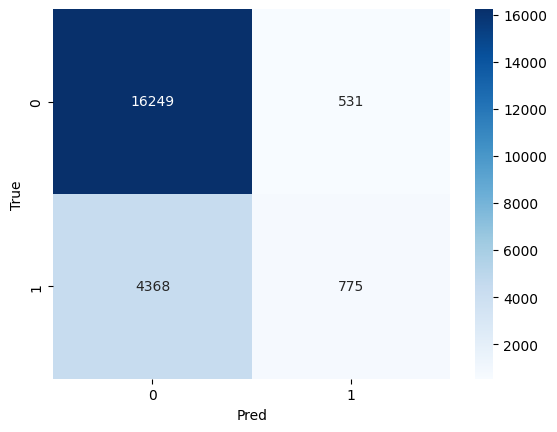

In [23]:
cm = confusion_matrix(y_test, y_pred)
h_map = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
h_map.set( xlabel = "Pred", ylabel = "True")

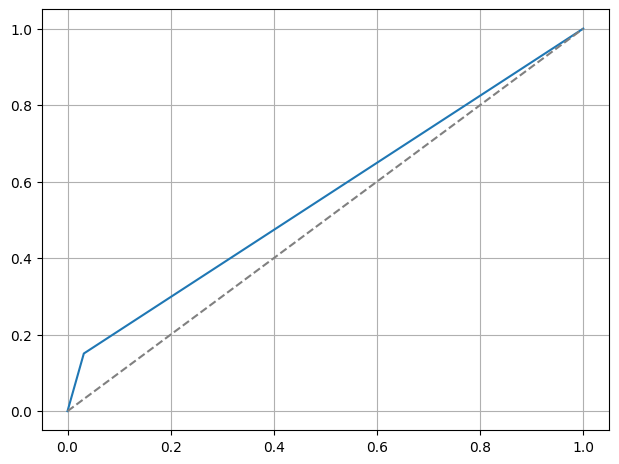

In [24]:
fig, ax = plt.subplots()

fpr, tpr, _ = roc_curve(y_test, y_pred)
ax.grid()
fig.tight_layout()
ax.plot(fpr, tpr)

ax.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='grey')

In [25]:
importance = pd.DataFrame(clf.feature_importances_, index=X_test.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
display(importance)

,importance
jockey,477
horse_trainer,291
horse_owner,283
horse_weight,232
id,143
race_name,131
day_of_year,104
date_cos,95
age,94
number_of_entries,88


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

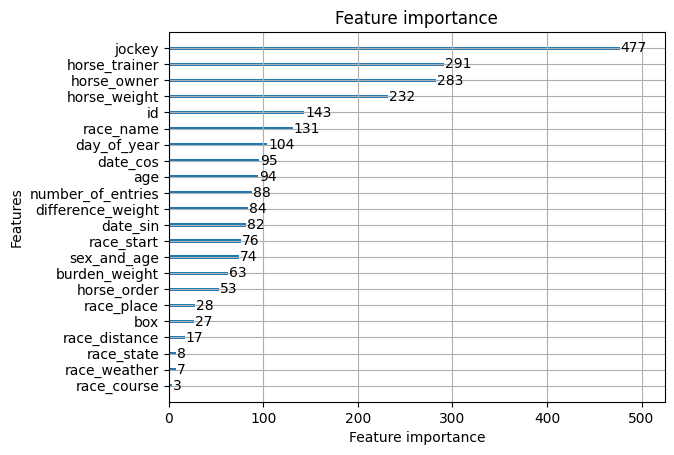

In [26]:
lgbm.plot_importance(clf)

In [27]:
from sqlalchemy import create_engine, Column, Integer, Float, String, DateTime, Text
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.dialects.mysql import JSON
from sqlalchemy import inspect
import datetime
import json

Base = declarative_base()

class ModelEvaluation(Base):
    __tablename__ = 'model_evaluation'
    id = Column(Integer, primary_key=True, autoincrement=True)
    feature_importance_json = Column(JSON)
    TP = Column(Integer)
    FP = Column(Integer)
    FN = Column(Integer)
    TN = Column(Integer)
    FPR = Column(JSON)
    TPR = Column(JSON)
    AUC = Column(Float)
    memo = Column(Text)
    version = Column(String(255))
    created_date = Column(DateTime, default=datetime.datetime.utcnow)

inspector = inspect(engine)

if not inspector.has_table(ModelEvaluation.__tablename__):
    Base.metadata.create_all(engine)
else:
    print(f"The table '{ModelEvaluation.__tablename__}' already exists in the database.")

Session = sessionmaker(bind=engine)
session = Session()

The table 'model_evaluation' already exists in the database.


/tmp/ipykernel_201/2181401413.py:9: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [28]:
importance_json = importance.to_json()
TN = int(cm[0][0])
FP = int(cm[0][1])
FN = int(cm[1][0])
TP = int(cm[1][1])
FPR = fpr.tolist()
TPR = tpr.tolist()
memo = "First model evaluation"
version = "v0.0"


new_evaluation = ModelEvaluation(
    feature_importance_json=importance_json,
    TP=TP,
    FP=FP,
    FN=FN,
    TN=TN,
    FPR=FPR,
    TPR=TPR,
    AUC=score,
    memo=memo,
    version=version,
    created_date=datetime.datetime.utcnow()
)

session.add(new_evaluation)

session.commit()

session.close()

In [29]:
!pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 36.8 MB/s eta 0:00:0000:0100:01
